In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
#Necessary libraries
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, BatchNormalization
import numpy as np
import skimage
import random
from tensorflow.keras.optimizers import Adam
import Denoise_layer # The custom built CVXPY layer

In [3]:
#Getting the MNIST dataset
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape #Shapes of the variables

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [5]:
#number of samples taken
train_num = 10000
test_num = 2000

In [6]:
#slicing the data
x_train = x_train[:train_num]
y_train = y_train[:train_num]
x_test = x_test[:test_num]
y_test = y_test[:test_num]

In [7]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((10000, 28, 28), (10000,), (2000, 28, 28), (2000,))

In [8]:
y_test.shape

(2000,)

In [9]:
#Finding total number of images in training and test set
print(len(x_train))
print(len(x_test))

10000
2000


In [10]:
#normalizing the entire data
x_train = x_train/255.0
x_test = x_test/255.0

In [11]:
#Reshaping and Normalizing training and test images
x_train = x_train.reshape(train_num, 28, 28, 1)

x_test = x_test.reshape(test_num, 28, 28, 1)


In [12]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((10000, 28, 28, 1), (10000,), (2000, 28, 28, 1), (2000,))

In [13]:
epochs = 10
batchSize = 32
opt = Adam(learning_rate=0.001)

In [14]:
#VGG model Building using Keras
def VGG16model():
  model = Sequential()

  model.add(Conv2D(32, 3, activation='relu', padding='same', input_shape=(28, 28, 1)))
  model.add(Conv2D(64, 3, activation='relu', padding='same'))
  model.add(MaxPooling2D(2, 2))
  model.add(BatchNormalization())

  model.add(Conv2D(128, 3, activation='relu', padding='same'))
  model.add(Conv2D(128, 3, activation='relu', padding='same'))
  model.add(MaxPooling2D(2, 2))
  model.add(BatchNormalization())

  model.add(Conv2D(256, 3, activation='relu', padding='same'))
  model.add(Conv2D(256, 3, activation='relu', padding='same'))
  model.add(Conv2D(256, 3, activation='relu', padding='same'))
  model.add(MaxPooling2D(2, 2))
  model.add(BatchNormalization())

  model.add(Conv2D(512, 3, activation='relu', padding='same'))
  model.add(Conv2D(512, 3, activation='relu', padding='same'))
  model.add(Conv2D(512, 3, activation='relu', padding='same'))
  model.add(MaxPooling2D(2, 1)) # default stride is 2
  model.add(BatchNormalization())

  model.add(Conv2D(512, 3, activation='relu', padding='same'))
  model.add(Conv2D(512, 3, activation='relu', padding='same'))
  model.add(Conv2D(512, 3, activation='relu', padding='same'))
  model.add(MaxPooling2D(2, 1)) # default stride is 2
  model.add(BatchNormalization())

  model.add(Flatten())
  model.add(Dense(4096, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(4096, activation='relu'))
  model.add(Dropout(0.5))

  model.add(Dense(10, activation='softmax'))
  model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=['accuracy'])
  return model

In [15]:
#The instance for the cvxpy layer
def CVXPYmodel(inp_shape, lam):
    
    denoise = Denoise_layer.Denoise(input_shape=inp_shape,lam_val=lam,trainable=False)
    model = Sequential()
    model.add(denoise)
    model.compile()
    
    return model 

In [16]:
from sklearn.metrics import classification_report,confusion_matrix

### Model-2

In [17]:
import skimage
import matplotlib.pyplot as plt

In [18]:
#Adding noise to the dataset with the level
import skimage
noise_lvl_1 = 0.3
noise_x_train_1 = np.array([skimage.util.random_noise(x, mode='gaussian', seed=42, clip=True, var = noise_lvl_1)  for x in x_train])
noise_x_test_1 = np.array([skimage.util.random_noise(x, mode='gaussian', seed=42, clip=True, var = noise_lvl_1) for x in x_test])

In [19]:
model_2 = VGG16model()

In [20]:
history_2 = model_2.fit(noise_x_train_1, y_train, epochs = epochs, batch_size = batchSize)#training the model

C:\Users\phvpa\anaconda3\envs\CVXPY\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Epoch 1/10
313/313 [==============================] - 28s 52ms/step - loss: 1.6296 - accuracy: 0.5580
Epoch 2/10
313/313 [==============================] - 12s 38ms/step - loss: 0.3829 - accuracy: 0.8923
Epoch 3/10
313/313 [==============================] - 11s 34ms/step - loss: 0.3591 - accuracy: 0.9028
Epoch 4/10
313/313 [==============================] - 11s 36ms/step - loss: 0.2386 - accuracy: 0.9365
Epoch 5/10
313/313 [==============================] - 11s 35ms/step - loss: 0.2285 - accuracy: 0.9449
Epoch 6/10
313/313 [==============================] - 12s 37ms/step - loss: 0.2984 - accuracy: 0.9324
Epoch 7/10
313/313 [==============================] - 12s 39ms/step - loss: 0.1850 - accuracy: 0.9531
Epoch 8/10
313/313 [==============================] - 11s 36ms/step - loss: 0.1952 - accuracy: 0.9529
Epoch 9/10
313/313 [==============================] - 11s 35ms/step - loss: 0.2052 - accuracy: 0.9477
Epoch 10/10
313/313 [==============================] - 12s 38ms/step - loss: 0.102

In [21]:
#Function for showing the accuracy and loss plots
def ShowPlots(hist):
  plt.figure(figsize=(16,6))
  plt.subplot(121)
  plt.plot(hist.history["accuracy"],'-ro',label="Accuracy")
  #plt.plot(hist.history["val_accuracy"],'-bo',label="Validation Accuracy")
  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.subplot(122)
  plt.plot(hist.history["loss"],'-ro',label="Loss")
  #plt.plot(hist.history["val_loss"],'-bo',label="Validation Loss")
  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  return plt.show()

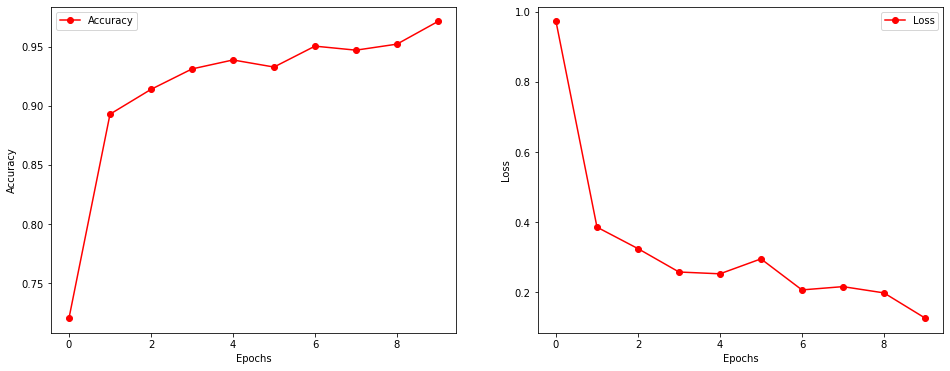

In [22]:
ShowPlots(history_2)

In [23]:
y_pred_2 = model_2.predict(noise_x_test_1)
y_pred_2 = np.argmax(y_pred_2,axis=1)

In [24]:
confusion_matrix(y_test,y_pred_2)

array([[169,   0,   0,   0,   0,   0,   6,   0,   0,   0],
       [  1, 231,   1,   1,   0,   0,   0,   0,   0,   0],
       [  8,   2, 208,   0,   0,   0,   1,   0,   0,   0],
       [  1,   0,   0, 201,   0,   1,   0,   0,   3,   1],
       [  2,   0,   0,   0, 198,   0,   9,   0,   1,   7],
       [  0,   0,   0,   3,   0, 168,   5,   1,   1,   1],
       [  0,   0,   0,   0,   0,   1, 177,   0,   0,   0],
       [  0,   2,  11,   1,   0,   0,   0, 184,   1,   6],
       [  0,   0,   1,   0,   0,   0,   0,   0, 191,   0],
       [  1,   0,   0,   0,   1,   0,   0,   0,   9, 183]], dtype=int64)

In [25]:
print(classification_report(y_test,y_pred_2))#classification report

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       175
           1       0.98      0.99      0.99       234
           2       0.94      0.95      0.95       219
           3       0.98      0.97      0.97       207
           4       0.99      0.91      0.95       217
           5       0.99      0.94      0.96       179
           6       0.89      0.99      0.94       178
           7       0.99      0.90      0.94       205
           8       0.93      0.99      0.96       192
           9       0.92      0.94      0.93       194

    accuracy                           0.95      2000
   macro avg       0.96      0.96      0.95      2000
weighted avg       0.96      0.95      0.96      2000



### Model-3
+ noise level = 0.3
+ lamda value = 0.2

In [26]:
cvxpy_layer_1 = CVXPYmodel((28,28),0.2)#making the cvxpy model

In [27]:
denoised_train_1 = cvxpy_layer_1.predict(noise_x_train_1.reshape(train_num,28,28)) #Denoising the input images

C:\Users\phvpa\anaconda3\envs\CVXPY\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


In [28]:
denoised_train_1.shape

(10000, 28, 28, 1)

In [29]:
model_3 = VGG16model()

In [30]:
history_3 = model_3.fit(denoised_train_1,y_train,epochs= epochs,batch_size= batchSize)#training the model with the denoised data

Epoch 1/10
313/313 [==============================] - 10s 33ms/step - loss: 9.5629 - accuracy: 0.1986
Epoch 2/10
313/313 [==============================] - 10s 33ms/step - loss: 1.6371 - accuracy: 0.3960
Epoch 3/10
313/313 [==============================] - 10s 33ms/step - loss: 1.2114 - accuracy: 0.5894
Epoch 4/10
313/313 [==============================] - 10s 32ms/step - loss: 0.9619 - accuracy: 0.7015
Epoch 5/10
313/313 [==============================] - 10s 33ms/step - loss: 0.7929 - accuracy: 0.7622
Epoch 6/10
313/313 [==============================] - 11s 34ms/step - loss: 0.6366 - accuracy: 0.8130
Epoch 7/10
313/313 [==============================] - 11s 34ms/step - loss: 0.6340 - accuracy: 0.8229
Epoch 8/10
313/313 [==============================] - 10s 33ms/step - loss: 0.5715 - accuracy: 0.8392
Epoch 9/10
313/313 [==============================] - 10s 33ms/step - loss: 0.6556 - accuracy: 0.8213
Epoch 10/10
313/313 [==============================] - 10s 33ms/step - loss: 0.502

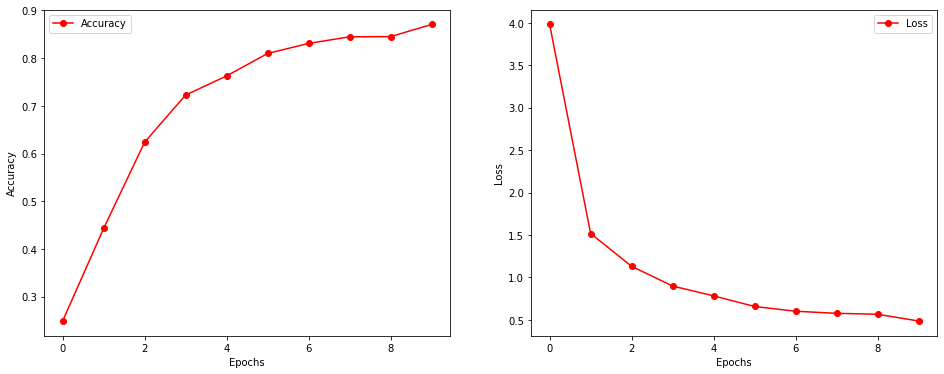

In [31]:
ShowPlots(history_3)

In [32]:
denoised_test_1 = cvxpy_layer_1.predict(noise_x_test_1.reshape(test_num,28,28))#Denoising the input images

In [34]:
denoised_test_1.shape

(2000, 28, 28, 1)

In [35]:
y_pred_3 = model_3.predict(denoised_test_1) #Predicting the denoised test data
y_pred_3 =np.argmax(y_pred_3,axis=1)

In [36]:
confusion_matrix(y_test,y_pred_3)

array([[163,   0,   0,   0,   5,   0,   7,   0,   0,   0],
       [  0, 231,   1,   0,   0,   0,   1,   0,   1,   0],
       [  0,   0, 188,   1,   0,   0,   7,   6,  10,   7],
       [  0,   0,   5, 184,   0,   4,   0,   1,  10,   3],
       [  0,   0,   0,   0, 210,   0,   3,   1,   0,   3],
       [  2,   0,   0,   2,   1, 157,  13,   0,   2,   2],
       [  2,   1,   1,   0,   1,   1, 172,   0,   0,   0],
       [  0,   1,   2,   0,   1,   0,   0, 194,   0,   7],
       [  0,   1,   2,   2,   0,   2,  20,   2, 156,   7],
       [  0,   0,   0,   2,   4,   1,   2,   5,   8, 172]], dtype=int64)

In [38]:
print(classification_report(y_test,y_pred_3))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95       175
           1       0.99      0.99      0.99       234
           2       0.94      0.86      0.90       219
           3       0.96      0.89      0.92       207
           4       0.95      0.97      0.96       217
           5       0.95      0.88      0.91       179
           6       0.76      0.97      0.85       178
           7       0.93      0.95      0.94       205
           8       0.83      0.81      0.82       192
           9       0.86      0.89      0.87       194

    accuracy                           0.91      2000
   macro avg       0.92      0.91      0.91      2000
weighted avg       0.92      0.91      0.91      2000



In [39]:
import math 
import numpy as np 
#function for calculating the PSNR value
def calculate_psnr(img1, img2): 
    # img1 and img2 have range [0, 255] 
    img1 = img1.astype(np.float64) 
    img2 = img2.astype(np.float64) 
    mse = np.mean((img1 - img2)**2) 
    if mse == 0:
        return float('inf') 
    return 20 * math.log10(1.0 / math.sqrt(mse))

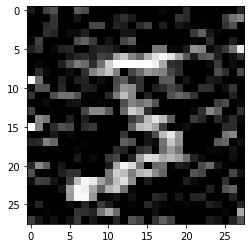

In [40]:
plt.imshow(denoised_train_1[0],cmap='gray')

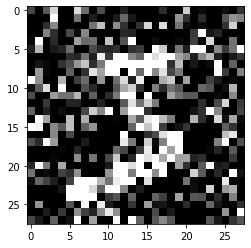

In [41]:
plt.imshow(noise_x_train_1[0],cmap='gray')

In [63]:
calculate_psnr(x_train[9999],denoised_train_1[9999])#1

13.05492094014192

In [64]:
calculate_psnr(x_train[9999],noise_x_train_1[9999]) #1

8.899396390234845

In [79]:
psnr_denoised_1 = 0
for i,j in zip(x_train,denoised_train_1):
    psnr_denoised_1 = calculate_psnr(i,j) + psnr_denoised_1
psnr_denoised_1 = psnr_denoised_1/x_train.shape[0]
psnr_denoised_1

12.632945246420089

In [80]:
psnr_noised_1 = 0
for i,j in zip(x_train,noise_x_train_1):
    psnr_noised_1 = calculate_psnr(i,j) + psnr_noised_1
psnr_noised_1 = psnr_noised_1/x_train.shape[0]
psnr_noised_1

8.92698713430124

### Model-4
+ noise level = 0.3
+ lambda value = 0.5

In [44]:
cvxpy_layer_2 = CVXPYmodel((28,28),0.5) #instance for cvxpy model

In [45]:
denoised_train_2 = cvxpy_layer_2.predict(noise_x_train_1.reshape(train_num,28,28)) #Denoising the input images

C:\Users\phvpa\anaconda3\envs\CVXPY\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


In [46]:
model_4 = VGG16model()

In [47]:
history_4 = model_4.fit(denoised_train_2,y_train,epochs= epochs,batch_size= batchSize)#training with the denoised images

Epoch 1/10
313/313 [==============================] - 10s 32ms/step - loss: 7.8054 - accuracy: 0.2187
Epoch 2/10
313/313 [==============================] - 10s 32ms/step - loss: 1.6992 - accuracy: 0.3483
Epoch 3/10
313/313 [==============================] - 10s 32ms/step - loss: 1.2982 - accuracy: 0.5155
Epoch 4/10
313/313 [==============================] - 10s 32ms/step - loss: 0.9474 - accuracy: 0.6766
Epoch 5/10
313/313 [==============================] - 11s 34ms/step - loss: 0.8375 - accuracy: 0.7240
Epoch 6/10
313/313 [==============================] - 10s 32ms/step - loss: 0.6511 - accuracy: 0.7925
Epoch 7/10
313/313 [==============================] - 10s 32ms/step - loss: 0.6097 - accuracy: 0.8129
Epoch 8/10
313/313 [==============================] - 10s 32ms/step - loss: 0.5157 - accuracy: 0.8461
Epoch 9/10
313/313 [==============================] - 10s 32ms/step - loss: 0.5627 - accuracy: 0.8423
Epoch 10/10
313/313 [==============================] - 10s 32ms/step - loss: 0.427

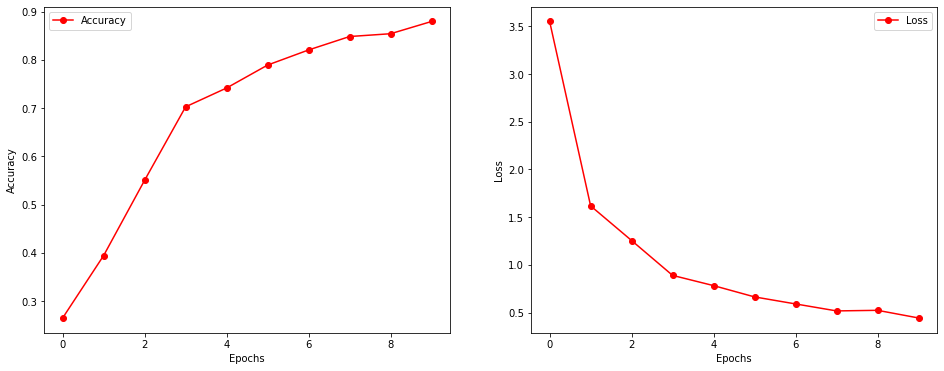

In [48]:
ShowPlots(history_4)

In [49]:
denoised_test_2 = cvxpy_layer_2.predict(noise_x_test_1.reshape(test_num,28,28)) #Denoising the input images-test

In [50]:
y_pred_4 = model_4.predict(denoised_test_2)#Predicting the denoised test data
y_pred_4 = np.argmax(y_pred_4,axis=1)

In [51]:
confusion_matrix(y_test,y_pred_4)#confusion matrix

array([[146,   0,   0,   0,   4,   2,  22,   0,   1,   0],
       [  0, 228,   0,   0,   4,   0,   0,   1,   1,   0],
       [ 10,   0, 173,   8,   3,   3,   4,   0,  17,   1],
       [  0,   0,   0, 129,   2,  10,   0,  20,   2,  44],
       [  0,   0,   0,   0, 217,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 154,   1,   1,   0,   0,  23],
       [  1,   1,   0,   0,  36,   0, 140,   0,   0,   0],
       [  0,   0,   1,   0,   3,   1,   0,  39,   1, 160],
       [  0,   0,   2,   1,  40,  96,  18,   0,  30,   5],
       [  0,   0,   0,   0,  83,   1,   0,   0,   0, 110]], dtype=int64)

In [52]:
print(classification_report(y_test,y_pred_4))

              precision    recall  f1-score   support

           0       0.93      0.83      0.88       175
           1       1.00      0.97      0.98       234
           2       0.98      0.79      0.88       219
           3       0.93      0.62      0.75       207
           4       0.40      1.00      0.57       217
           5       0.01      0.01      0.01       179
           6       0.76      0.79      0.77       178
           7       0.65      0.19      0.29       205
           8       0.58      0.16      0.25       192
           9       0.32      0.57      0.41       194

    accuracy                           0.61      2000
   macro avg       0.66      0.59      0.58      2000
weighted avg       0.67      0.61      0.59      2000



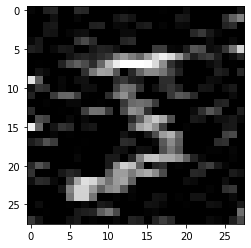

In [53]:
plt.imshow(denoised_train_2[0],cmap='gray')#denoised image

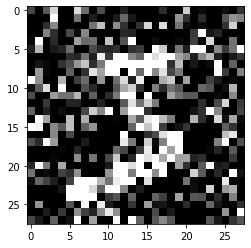

In [54]:
plt.imshow(noise_x_train_1[0],cmap='gray')#noise image

In [55]:
calculate_psnr(x_train[0],denoised_train_2[0])#1

13.382189743155239

In [75]:
psnr_denoised = 0
for i,j in zip(x_train,denoised_train_2):
    psnr_denoised = calculate_psnr(i,j) + psnr_denoised
psnr_denoised = psnr_denoised/x_train.shape[0]
psnr_denoised

12.942571987446506

In [76]:
psnr_noised = 0
for i,j in zip(x_train,noise_x_train_1):
    psnr_noised = calculate_psnr(i,j) + psnr_noised
psnr_noised = psnr_noised/x_train.shape[0]
psnr_noised

8.92698713430124

In [56]:
calculate_psnr(x_train[0],noise_x_train_1[0])

9.129734078556682

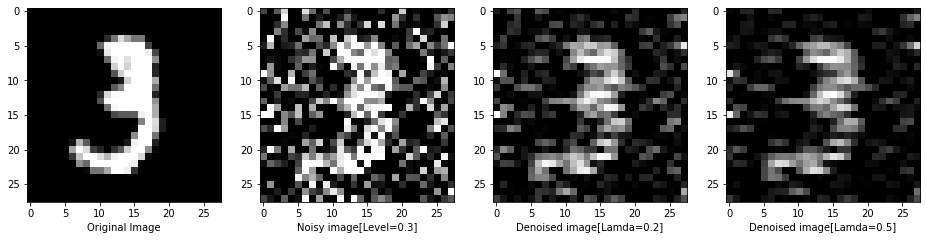

In [57]:
fig = plt.figure(figsize=(16,8))

plt.subplot(1, 4, 1)
plt.imshow(x_train[10].reshape(28,28),cmap='gray')
plt.xlabel("Original Image")
plt.subplot(1, 4, 2)
plt.imshow(noise_x_train_1[10].reshape(28,28),cmap='gray')
plt.xlabel("Noisy image[Level=0.3]")
plt.subplot(1, 4, 3)
plt.imshow(denoised_train_1[10].reshape(28,28),cmap='gray')
plt.xlabel("Denoised image[Lamda=0.2]")
plt.subplot(1, 4, 4)
plt.imshow(denoised_train_2[10].reshape(28,28),cmap='gray')
plt.xlabel("Denoised image[Lamda=0.5]")
plt.show()